In [1]:
# Initial imports.
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import linear_model

from imblearn.metrics import classification_report_imbalanced

import psycopg2
import matplotlib. pyplot as plt 
import seaborn as sns

from collections import Counter
from config import password

In [2]:
# Load the pga data set dataset from database 
connection_string = f"host=red-team-final.c3yshvuxvm9x.us-east-2.rds.amazonaws.com dbname=red-team port=5432 user=postgres password={password}"
connection = psycopg2.connect(connection_string)

In [3]:
# Establish connection and db
sql = "select * from pga_stats"
pga_df = pd.read_sql(sql, connection)

In [4]:
# Show df
pga_df = pga_df.rename(columns={"money_MONEY":"Winnings"})
pga_df

,SG_off_tee_AVERAGE,SG_tee_green_AVERAGE,driving_dist_AVG.,pct_ydg_tee_AVG (%),driving_320+_%,SG_approach_green_AVERAGE,GIR_pct_%,GOFIR_pct_%,GIR_pct_fwy_%,GIR_pct_not_fwy_%,...,pct_sand_save_%,scrambling_%,SG_putt_AVERAGE,pct_one_putt_%,pct_three_putt_avoid_%,putt_avg_AVG,putts_per_rd_AVG,bogey_avoid_% MAKES BOGEY,btb_ratio_BIRDIE TO BOGEY RATIO,Winnings
0,1.144,2.099,321.1,66.80,51.47,0.696,66.67,80.34,80.87,50.25,...,48.89,61.27,0.435,41.01,3.27,1.752,28.74,14.54,1.84,5443091
1,0.841,1.700,307.1,64.01,29.17,0.582,72.11,85.90,83.80,57.32,...,50.00,63.07,-0.019,38.43,2.55,1.750,29.04,14.00,1.79,3556232
2,0.774,1.064,318.2,64.96,48.68,0.178,65.35,74.37,79.47,53.10,...,57.35,57.81,0.040,42.11,3.36,1.743,28.76,17.11,1.48,1782342
3,0.610,0.833,299.9,63.64,13.28,0.553,73.18,79.81,80.52,65.29,...,46.05,61.49,-0.013,37.67,2.52,1.756,29.30,12.50,1.91,1482028
4,0.567,0.563,287.4,60.36,8.33,-0.088,64.81,68.25,72.54,51.09,...,52.50,60.53,-0.793,39.12,2.78,1.779,29.25,15.74,1.15,164271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,-0.063,0.284,300.9,63.32,16.67,0.585,66.43,73.44,76.26,54.23,...,56.10,58.99,-0.113,36.55,3.22,1.807,29.45,16.26,1.17,824162
461,-0.417,-0.168,278.7,60.89,1.92,-0.006,63.53,68.20,73.63,48.14,...,54.17,62.30,0.451,42.02,1.42,1.748,28.32,15.03,1.27,942372
462,0.022,-0.402,285.1,62.05,1.69,-0.429,64.69,69.61,77.00,52.37,...,51.35,58.67,-0.006,38.51,2.73,1.779,29.15,16.95,1.14,332352
463,0.255,0.325,296.4,63.35,13.27,0.251,66.07,71.07,76.71,51.13,...,51.45,56.98,0.154,38.78,3.05,1.772,29.08,17.05,1.24,1943309


C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


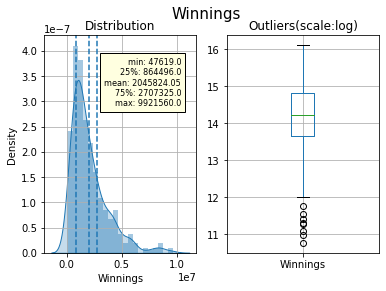

In [5]:
# Code form towarddatascience.com ammended for our own explanatory analysis

# Set variable
x = "Winnings"
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=15)

# Distribution
ax[0].title.set_text('Distribution')
var = pga_df[x].fillna(pga_df[x].mean())
breaks = np.quantile(var, q=np.linspace(0, 1, 11))
var = var[ (var > breaks[0]) & (var < 
                    breaks[10]) ]
sns.distplot(var, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = pga_df[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.9, 0.9, box, transform=ax[0].transAxes, fontsize=8, va='top', ha="right", bbox=dict(facecolor='lightyellow', alpha=1))

# Box plot 
ax[1].title.set_text('Outliers(scale:log)')
tmp_df = pd.DataFrame(pga_df[x])
tmp_df[x] = np.log(tmp_df[x])
tmp_df.boxplot(column=x, ax=ax[1])
plt.show()

In [6]:
# Define the features set as everything but money 
X = pga_df.drop("Winnings", axis=1)
X.head()

,SG_off_tee_AVERAGE,SG_tee_green_AVERAGE,driving_dist_AVG.,pct_ydg_tee_AVG (%),driving_320+_%,SG_approach_green_AVERAGE,GIR_pct_%,GOFIR_pct_%,GIR_pct_fwy_%,GIR_pct_not_fwy_%,...,SG_ATG_AVERAGE,pct_sand_save_%,scrambling_%,SG_putt_AVERAGE,pct_one_putt_%,pct_three_putt_avoid_%,putt_avg_AVG,putts_per_rd_AVG,bogey_avoid_% MAKES BOGEY,btb_ratio_BIRDIE TO BOGEY RATIO
0,1.144,2.099,321.1,66.80,51.47,0.696,66.67,80.34,80.87,50.25,...,0.259,48.89,61.27,0.435,41.01,3.27,1.752,28.74,14.54,1.84
1,0.841,1.700,307.1,64.01,29.17,0.582,72.11,85.90,83.80,57.32,...,0.326,50.00,63.07,-0.019,38.43,2.55,1.750,29.04,14.00,1.79
2,0.774,1.064,318.2,64.96,48.68,0.178,65.35,74.37,79.47,53.10,...,0.112,57.35,57.81,0.040,42.11,3.36,1.743,28.76,17.11,1.48
3,0.610,0.833,299.9,63.64,13.28,0.553,73.18,79.81,80.52,65.29,...,-0.329,46.05,61.49,-0.013,37.67,2.52,1.756,29.30,12.50,1.91
4,0.567,0.563,287.4,60.36,8.33,-0.088,64.81,68.25,72.54,51.09,...,0.084,52.50,60.53,-0.793,39.12,2.78,1.779,29.25,15.74,1.15


In [7]:
# Define the target set as Money/ Earning PGA
y = pga_df[["Winnings"]]
y.head()

,Winnings
0,5443091
1,3556232
2,1782342
3,1482028
4,164271


In [8]:
# See stats
X.describe()

,SG_off_tee_AVERAGE,SG_tee_green_AVERAGE,driving_dist_AVG.,pct_ydg_tee_AVG (%),driving_320+_%,SG_approach_green_AVERAGE,GIR_pct_%,GOFIR_pct_%,GIR_pct_fwy_%,GIR_pct_not_fwy_%,...,SG_ATG_AVERAGE,pct_sand_save_%,scrambling_%,SG_putt_AVERAGE,pct_one_putt_%,pct_three_putt_avoid_%,putt_avg_AVG,putts_per_rd_AVG,bogey_avoid_% MAKES BOGEY,btb_ratio_BIRDIE TO BOGEY RATIO
count,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,...,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000
mean,0.098768,0.346110,296.352258,62.827849,14.570151,0.163426,66.595914,72.710043,77.570946,52.093462,...,0.083004,51.093075,59.746151,0.074660,39.514387,2.835398,1.760247,28.931742,15.828022,1.381376
std,0.356667,0.610017,8.522126,1.418809,9.723791,0.336851,2.470341,3.185690,2.812644,3.721184,...,0.211679,6.282326,3.333367,0.354373,2.203442,0.649185,0.027451,0.496314,1.719330,0.233647
min,-1.351000,-1.973000,272.600000,58.840000,0.000000,-0.643000,57.640000,61.470000,69.830000,40.100000,...,-0.437000,32.200000,49.260000,-1.159000,33.750000,1.390000,1.666000,27.500000,10.990000,0.750000
25%,-0.123000,-0.033000,290.400000,61.940000,7.320000,-0.072000,64.810000,70.610000,75.760000,49.880000,...,-0.062000,47.010000,57.610000,-0.152000,37.980000,2.360000,1.743000,28.580000,14.710000,1.240000
50%,0.094000,0.342000,296.300000,62.750000,12.180000,0.172000,66.670000,72.620000,77.780000,52.210000,...,0.071000,51.280000,59.900000,0.067000,39.520000,2.780000,1.762000,28.920000,15.720000,1.340000
75%,0.312000,0.739000,301.900000,63.660000,19.000000,0.408000,68.360000,74.760000,79.580000,54.170000,...,0.234000,55.560000,62.110000,0.336000,41.000000,3.270000,1.778000,29.280000,16.780000,1.500000
max,1.195000,2.126000,322.100000,67.880000,56.450000,1.051000,73.180000,85.900000,85.330000,65.290000,...,0.997000,68.550000,70.970000,1.101000,45.990000,4.860000,1.847000,30.360000,23.190000,2.360000


In [9]:
# Split Data into testing and training 
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(Counter(y_train))
print("X_train shape:", X_train.shape, "| X_test shape:", y_train.shape)
print("y_train mean:", round(np.mean(y_train),2), "| y_test mean:", round(np.mean(y_test),2))

Counter({'Winnings': 1})
X_train shape: (348, 22) | X_test shape: (348, 1)
y_train mean: Winnings    2005653.54
dtype: float64 | y_test mean: Winnings    2165305.55
dtype: float64


In [10]:
# Scale data
# Scale X
scaler = StandardScaler()
X = scaler.fit_transform(X_train)
df_scaled_X = pd.DataFrame(X, columns=X_train.columns, index=X_train.index)

# Scale Y
y = scaler.fit_transform(y_train)
df_scaled_y = pd.DataFrame(y, columns=y_train.columns, index=y_train.index)

In [11]:
# Make scaled df
df_scaled = df_scaled_X.join(df_scaled_y)
df_scaled

,SG_off_tee_AVERAGE,SG_tee_green_AVERAGE,driving_dist_AVG.,pct_ydg_tee_AVG (%),driving_320+_%,SG_approach_green_AVERAGE,GIR_pct_%,GOFIR_pct_%,GIR_pct_fwy_%,GIR_pct_not_fwy_%,...,pct_sand_save_%,scrambling_%,SG_putt_AVERAGE,pct_one_putt_%,pct_three_putt_avoid_%,putt_avg_AVG,putts_per_rd_AVG,bogey_avoid_% MAKES BOGEY,btb_ratio_BIRDIE TO BOGEY RATIO,Winnings
232,-0.280027,0.588251,-0.901396,-1.064867,-0.836712,1.209033,0.976840,0.709591,0.011792,0.263570,...,1.409057,0.732978,-0.683961,-0.885777,0.470389,0.634330,0.738298,-0.940313,0.304395,-0.513453
206,0.629955,0.727291,-0.080136,-0.385724,-0.327272,0.462671,0.609795,0.471864,-0.163583,0.507678,...,1.336064,1.511810,0.265933,0.072270,0.067237,0.020844,-0.078058,-1.355408,1.229176,0.357848
394,-2.422979,-1.013949,-1.889289,-1.772910,-1.121191,-0.242715,-0.906787,-1.249395,-1.503451,-0.357550,...,0.333631,-0.228762,0.156975,0.377734,0.036225,0.489980,-0.118876,0.708846,-0.956670,-0.713470
307,1.247844,0.391007,1.609995,1.427733,1.698383,0.208029,1.049442,0.884124,0.751877,1.058277,...,-0.467666,-2.078488,-1.801484,-2.547316,1.354222,2.005653,2.860826,1.045409,-1.082777,0.167934
202,-0.178918,-0.236292,-0.139647,-0.234000,-0.528022,0.655847,-0.051693,-0.701722,0.208213,-0.308728,...,-1.875613,-1.574017,-0.633672,-0.575684,0.129260,-0.087419,0.840343,0.933221,-0.998706,-0.315779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,-0.249133,0.082208,-0.199159,-0.017253,-0.333325,-0.181250,-0.221099,-1.059816,-0.146045,-0.276180,...,-0.143254,-1.305556,-1.645030,-1.339344,1.137141,1.175642,1.493428,1.359534,-1.250919,-0.372058
297,0.357522,0.138794,0.967269,1.160411,1.484519,0.184614,-0.422772,-0.470014,-0.602021,-0.585384,...,-0.402783,-0.529674,0.355335,-0.159142,0.020719,0.056931,0.452574,0.512517,-0.410209,1.201167
14,0.773192,1.186448,1.300535,1.261560,1.333200,1.089030,0.359720,1.124860,0.502844,1.212879,...,2.437442,-0.547375,1.981331,1.687527,0.951070,-1.603091,-0.935233,0.344236,0.640679,0.481236
126,0.388416,0.085442,0.634004,0.401793,-0.211261,0.044122,1.561692,0.811903,2.119805,-0.197523,...,-3.030520,0.373063,-1.580773,-1.890105,2.424126,1.608691,1.819971,-0.278406,-0.031889,-1.042914


<AxesSubplot:title={'center':'pearson correlation'}>

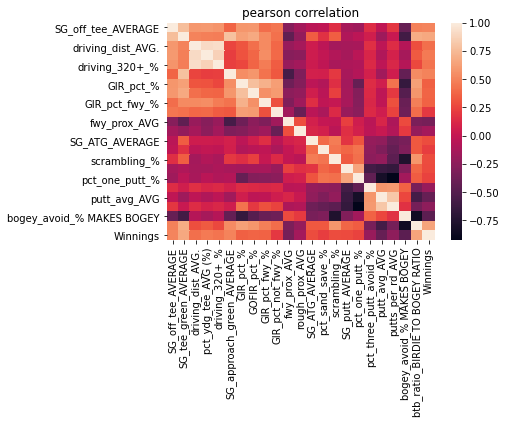

In [12]:
# Show correlation matrix
# Learned about pearson method from towarddatascience
c_matrix = df_scaled.corr(method="pearson")
plt.title("pearson correlation")
sns.heatmap(c_matrix)

In [13]:
# Call Linear Regression model
model = linear_model.LinearRegression()

# # Prep X-train data
# Xt = pd.DataFrame(X)
# Xt.columns = X_train.columns

# # Prep y-train data
# yt = pd.DataFrame(y)
# yt.columns = y_train.columns

# Train data to model 
model.fit(df_scaled_X, df_scaled_y)

LinearRegression()

In [14]:
# Predict
y_pred = model.predict(X_test)
y_pred

array([[-117.01381636],
       [-113.72995089],
       [-114.54156979],
       [-116.67660106],
       [-114.21348812],
       [-115.07815835],
       [-115.00022521],
       [-115.84647109],
       [-115.42018223],
       [-117.21146617],
       [-116.00716491],
       [-112.71836353],
       [-112.64478255],
       [-117.42169261],
       [-117.60199361],
       [-114.33829158],
       [-116.13917378],
       [-118.05988501],
       [-118.27205422],
       [-115.76963872],
       [-115.32185741],
       [-115.49199645],
       [-117.06273118],
       [-112.21283966],
       [-115.28510837],
       [-117.11145186],
       [-115.66778877],
       [-112.37103649],
       [-115.03089507],
       [-116.43312372],
       [-114.80766403],
       [-116.24949905],
       [-117.48597224],
       [-115.29081141],
       [-116.58710406],
       [-113.66123614],
       [-119.93403965],
       [-114.21937866],
       [-115.77148998],
       [-113.83657909],
       [-115.72484069],
       [-115.917